# Classification

In [1]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
colors = {
    "Blue": "#1f77b4",
    "Green": "#2ca02c",
    "Red": "#d62728",
    "Grey": "#7f7f7f",
}

from datetime import datetime
import holidays

from pyspark.sql import SparkSession
import os

event_log_dir = "/tmp/spark-events"
os.makedirs(event_log_dir, exist_ok=True)
total_memory_gb = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024. ** 3)

spark = SparkSession.builder \
    .appName("ClassificationDDAM") \
    .config("spark.executor.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.driver.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/tmp/spark-events") \
    .getOrCreate()

sc = spark.sparkContext

file_path = '/content/drive/MyDrive/DDAM Group 2/clf_credit.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

Mounted at /content/drive


In [ ]:
spark.version

'3.5.3'

In [ ]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.3
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.25
Branch HEAD
Compiled by user haejoon.lee on 2024-09-09T05:20:05Z
Revision 32232e9ed33bb16b93ad58cfde8b82e0f07c0970
Url https://github.com/apache/spark
Type --help for more information.


In [ ]:
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- merchant: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)
 |-- Income_2019: integer (nullable = true)
 |-- Income_2020: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nu

In [2]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import functions as F

from pyspark.sql.functions import col, when, count
import math

def calculate_confusion_matrix(predictions, label_col="is_fraud", prediction_col="prediction"):
    confusion = predictions.groupBy(label_col, prediction_col).count().collect()

    counts = {(row[label_col], row[prediction_col]): row['count'] for row in confusion}

    TP = counts.get((1, 1), 0)
    TN = counts.get((0, 0), 0)
    FP = counts.get((0, 1), 0)
    FN = counts.get((1, 0), 0)

    return TP, TN, FP, FN

def compute_metrics(predictions):
    TP, TN, FP, FN = calculate_confusion_matrix(predictions)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    g_measure = math.sqrt(precision * recall) if precision > 0 and recall > 0 else 0
    jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    return g_measure, jaccard_index

In [3]:
clf_df = df.drop("state", 'category', 'Unnamed: 0', 'cc_num', 'merchant', 'street', 'city','zip', 'job',
                'trans_num', 'merch_zipcode')
clf_df = clf_df.fillna(0)

fractions = {0: 0.8, 1: 0.8}  # Class 0 (non-fraud) and class 1 (fraud)
#  stratified sampling preserving class distribution is_fraud
train_df = clf_df.sampleBy("is_fraud", fractions, seed=42)
valid_df = clf_df.subtract(train_df)

feature_columns = [col for col in clf_df.columns if col != 'is_fraud']

In [4]:
feature_columns

['amt',
 'gender',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'Income_2019',
 'Income_2020',
 'age',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'is_holiday',
 'daily_tran',
 'daily_avg_spent',
 'entertainment',
 'food_dining',
 'gas_transport',
 'grocery_net',
 'grocery_pos',
 'health_fitness',
 'home',
 'kids_pets',
 'misc_net',
 'misc_pos',
 'personal_care',
 'shopping_net',
 'shopping_pos',
 'travel',
 'online',
 'cat_enc',
 'st_enc']

In [5]:
len(feature_columns)

36

In [6]:
# first part of the pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

## Baseline

In [ ]:
%%time
'''
DUMMY CLASSIFIER (baseline model)
'''
majority_class = train_df.groupby("is_fraud").count().orderBy(F.desc("count")).first()[0]

dummy_predictions = valid_df.withColumn("prediction", F.lit(majority_class).cast("double"))
dummy_predictions = dummy_predictions.withColumn("is_fraud", dummy_predictions["is_fraud"].cast("double"))

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(dummy_predictions)

prediction_and_labels = dummy_predictions.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0) # for positive class (is_fraud=1)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(dummy_predictions)

dummy_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Dummy Classifier Metrics:")
for metric, value in dummy_metrics.items():
    print(f"{metric}: {value}")

ROC-AUC on validation set: 0.5


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Dummy Classifier Metrics:
confusion_matrix: [[258128.      0.]
 [  1456.      0.]]
precision: 0.0
recall: 0.0
f1_score: 0.0
accuracy: 0.9943910256410257
g-measure: 0
jaccard_index: 0.0
roc_auc: 0.5
CPU times: user 917 ms, sys: 127 ms, total: 1.04 s
Wall time: 3min 2s


In [ ]:
%%time
'''
BASE DT MODEL
'''
dt_classifier = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="features", maxDepth=5)

pipeline = Pipeline(stages=[assembler, scaler, dt_classifier])
dt_model = pipeline.fit(train_df)

predictions = dt_model.transform(valid_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

prediction_and_labels = predictions.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(predictions)

dt_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Decision Tree Classifier Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value}")

ROC-AUC on validation set: 0.8493111385704886


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Decision Tree Classifier Metrics:
confusion_matrix: [[2.57924e+05 2.04000e+02]
 [5.38000e+02 9.18000e+02]]
precision: 0.8181818181818182
recall: 0.6304945054945055
f1_score: 0.7121799844840961
accuracy: 0.9971415803747534
g-measure: 0.7182333470809754
jaccard_index: 0.553012048192771
roc_auc: 0.8493111385704886
CPU times: user 1.16 s, sys: 137 ms, total: 1.29 s
Wall time: 4min 5s


## Undersampling + Oversampling

Applied on train_df

In [ ]:
train_df.groupBy("is_fraud").count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   6050|
|       0|1031041|
+--------+-------+



In [ ]:
valid_df.groupBy("is_fraud").count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  1456|
|       0|258128|
+--------+------+



In [5]:
%%time
from pyspark.sql.functions import col
from imblearn.over_sampling import ADASYN
import pandas as pd

def random_undersampling(df, label_col="is_fraud", seed=42):
    majority_class = df.filter(col(label_col) == 0)
    minority_class = df.filter(col(label_col) == 1)

    # undersample majority class to match a fraction of the minority class size
    majority_count = minority_class.count() * 50  # 50 times the minority class size
    majority_sampled = majority_class.sample(withReplacement=False, fraction=majority_count / majority_class.count(), seed=seed)

    # combine data
    balanced_df = majority_sampled.union(minority_class)
    return balanced_df

def apply_adasyn(df, label_col="is_fraud", feature_cols=None):
    pandas_df = df.toPandas()

    X = pandas_df[feature_cols]
    y = pandas_df[label_col]

    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    resampled_df = pd.DataFrame(X_resampled, columns=feature_cols)
    resampled_df[label_col] = y_resampled

    spark_resampled_df = spark.createDataFrame(resampled_df)
    return spark_resampled_df

# balancing data with RU+ADASYN
balanced_df = random_undersampling(train_df, label_col="is_fraud")
balanced_df = apply_adasyn(balanced_df, label_col="is_fraud", feature_cols=feature_columns)
balanced_df.groupBy("is_fraud").count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       0|302894|
|       1|304161|
+--------+------+

CPU times: user 2min 20s, sys: 1.82 s, total: 2min 22s
Wall time: 3min 15s


In [6]:
import gc
gc.collect()

156

In [7]:
%%time
'''
DUMMY CLASSIFIER on balanced data
'''
majority_class = balanced_df.groupby("is_fraud").count().orderBy(F.desc("count")).first()[0]
dummy_predictions = valid_df.withColumn("prediction", F.lit(majority_class).cast("double"))
dummy_predictions = dummy_predictions.withColumn("is_fraud", dummy_predictions["is_fraud"].cast("double"))

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(dummy_predictions)
prediction_and_labels = dummy_predictions.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy

g_measure, jaccard_index = compute_metrics(dummy_predictions)

dummy_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Dummy Classifier Metrics:")
for metric, value in dummy_metrics.items():
    print(f"{metric}: {value}")

ROC-AUC on validation set: 0.5


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Dummy Classifier Metrics:
confusion_matrix: [[     0. 258128.]
 [     0.   1456.]]
precision: 0.005608974358974359
recall: 1.0
f1_score: 0.011155378486055776
accuracy: 0.005608974358974359
g-measure: 0.07489308618940976
jaccard_index: 0.005608974358974359
roc_auc: 0.5
CPU times: user 758 ms, sys: 82.5 ms, total: 840 ms
Wall time: 2min 40s


In [ ]:
%%time
dt_classifier = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="features", maxDepth=5)
pipeline = Pipeline(stages=[assembler, scaler, dt_classifier])
dt_model_balanced = pipeline.fit(balanced_df)

predictions_balanced = dt_model_balanced.transform(valid_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions_balanced)

prediction_and_labels = predictions_balanced.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(predictions_balanced)

dt_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Decision Tree Classifier Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Decision Tree Classifier Metrics:
confusion_matrix: [[2.39415e+05 1.87130e+04]
 [1.61000e+02 1.29500e+03]]
precision: 0.06472411035585765
recall: 0.8894230769230769
f1_score: 0.12066716362281027
accuracy: 0.9272913584812623
g-measure: 0.23993148476974774
jaccard_index: 0.06420744707223958
roc_auc: 0.8177316396993265
CPU times: user 863 ms, sys: 98.6 ms, total: 962 ms
Wall time: 3min 3s


## Logistic Regression

In [ ]:
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

lr_classifier = LogisticRegression(labelCol="is_fraud", featuresCol="features", maxIter=10, regParam=0.01)

pipeline = Pipeline(stages=[assembler, scaler, lr_classifier])
lr_model_balanced = pipeline.fit(balanced_df)
predictions_balanced = lr_model_balanced.transform(valid_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions_balanced)

prediction_and_labels = predictions_balanced.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(predictions_balanced)

lr_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Logistic Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value}")

ROC-AUC on validation set: 0.8968015665879693


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression Metrics:
confusion_matrix: [[230875.  27253.]
 [   305.   1151.]]
precision: 0.04052246162512322
recall: 0.790521978021978
f1_score: 0.07709310113864702
accuracy: 0.8938378328402367
g-measure: 0.17898015677223023
jaccard_index: 0.040091957225957014
roc_auc: 0.8968015665879693
CPU times: user 873 ms, sys: 99.6 ms, total: 972 ms
Wall time: 3min 11s


## Random Forest

In [ ]:
%%time
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=10, maxDepth=10)
pipeline = Pipeline(stages=[assembler, scaler, rf_classifier])

rf_model_balanced = pipeline.fit(balanced_df)

predictions_balanced = rf_model_balanced.transform(valid_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions_balanced)
prediction_and_labels = predictions_balanced.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy

g_measure, jaccard_index = compute_metrics(predictions_balanced)

rf_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("Random Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

ROC-AUC on validation set: 0.9707056859685589


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Random Forest Metrics:
confusion_matrix: [[2.46488e+05 1.16400e+04]
 [1.70000e+02 1.28600e+03]]
precision: 0.09948940120686987
recall: 0.8832417582417582
f1_score: 0.17883465442914756
accuracy: 0.9545041296844181
g-measure: 0.29643413037026534
jaccard_index: 0.0981979230299328
roc_auc: 0.9707056859685589
CPU times: user 919 ms, sys: 117 ms, total: 1.04 s
Wall time: 3min 24s


## XGBoost

In [ ]:
!pip install xgboost -q -q -q

In [47]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import multiprocessing
num_workers = multiprocessing.cpu_count()

xgb_classifier = SparkXGBClassifier(
    label_col="is_fraud",
    features_col="features",
    num_workers = num_workers,
    device='cpu',
    num_boost_round=50,
    verbose_eval=True
)

pipeline = Pipeline(stages=[assembler, scaler, xgb_classifier])
xgb_model_balanced = pipeline.fit(balanced_df)

predictions_balanced = xgb_model_balanced.transform(valid_df)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions_balanced)
prediction_and_labels = predictions_balanced.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(predictions_balanced)

xgb_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("XGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")

INFO:XGBoost-PySpark:Running xgboost-2.1.3 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


ROC-AUC on validation set: 0.9980134666662519


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


XGBoost Metrics:
confusion_matrix: [[2.56568e+05 1.56000e+03]
 [6.60000e+01 1.39000e+03]]
precision: 0.4711864406779661
recall: 0.9546703296703297
f1_score: 0.6309577848388561
accuracy: 0.9937361316568047
g-measure: 0.6309577848388561
jaccard_index: 0.4608753315649867
roc_auc: 0.9980134666662519


In [9]:
#predictions_balanced.printSchema()

In [ ]:
predictions_balanced.select('probability').show(2, truncate=False)

+-----------------------------------------+
|probability                              |
+-----------------------------------------+
|[0.9998719692230225,1.280122232856229E-4]|
|[0.9997555017471313,2.444909478072077E-4]|
+-----------------------------------------+
only showing top 2 rows



In [ ]:
predictions_balanced.select("probability").take(1)

[Row(probability=DenseVector([0.9999, 0.0001]))]

In [15]:
# save model
xgb_classifier_model_path = "/content/drive/MyDrive/DDAM Group 2/AM/xgb_model_balanced"
xgb_model_balanced.stages[-1].write().overwrite().save(xgb_classifier_model_path)

'''
load:
from pyspark.ml import PipelineModel

# Load the entire pipeline model
loaded_pipeline_model = PipelineModel.load(pipeline_model_path)
'''

'\nload:\nfrom pyspark.ml import PipelineModel\n\n# Load the entire pipeline model\nloaded_pipeline_model = PipelineModel.load(pipeline_model_path)\n'

#### XGBoost with SMOTE

In [7]:
from pyspark.sql.functions import col, rand
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType

def random_undersampling(df, label_col="is_fraud", seed=42):
    majority_class = df.filter(col(label_col) == 0)
    minority_class = df.filter(col(label_col) == 1)

    minority_count = minority_class.count()
    majority_count = minority_count * 50
    majority_sampled = majority_class.sample(withReplacement=False, fraction=majority_count / majority_class.count(), seed=seed)

    balanced_df = majority_sampled.union(minority_class)
    return balanced_df

from pyspark.sql import Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql import functions as F
import numpy as np
from random import randint

def apply_smote(df, label_col="is_fraud", feature_cols=None, k=5, synthetic_ratio=1.0):
    """
    Implements a SMOTE-like method in PySpark to generate synthetic samples for the minority class.

    This version:
    - Uses broadcast variables for minority data.
    - Uses NumPy vectorization to speed distance computations.
    - Parallelizes the synthetic sample generation step.

    Args:
        df: PySpark DataFrame.
        label_col: Column name for labels.
        feature_cols: List of feature column names.
        k: Number of nearest neighbors.
        synthetic_ratio: Number of synthetic samples to generate per original minority sample.

    Returns:
        PySpark DataFrame with synthetic samples added.
    """
    if feature_cols is None:
        raise ValueError("feature_cols must be specified.")

    data_rdd = df.select(feature_cols + [label_col]) \
                  .rdd.map(lambda row: (row[label_col], np.array([row[f] for f in feature_cols], dtype=np.float64)))

    minority_rdd = data_rdd.filter(lambda x: x[0] == 1).map(lambda x: x[1])
    majority_rdd = data_rdd.filter(lambda x: x[0] == 0)

    minority_data = minority_rdd.collect()
    minority_data = np.array(minority_data)  # shape: (num_minority, num_features)

    sc = df.sparkSession.sparkContext
    minority_bcast = sc.broadcast(minority_data)

    def generate_synthetic_samples(point):
        """
        For a given minority point, find k-nearest neighbors within minority_bcast,
        and generate synthetic samples.
        """
        all_points = minority_bcast.value
        # Compute squared distances to all other points
        diff = all_points - point
        dist = np.sum(diff**2, axis=1)

        # dist includes distance to itself, so we set that to a large number to exclude it
        # or we can just find k+1 smallest and skip the zero-dist at index of the point itself.
        # But since we do not know the index of the point in all_points here, we just remove it manually later.

        # Find the k+1 smallest distances
        # We'll sort or use partition; np.argpartition is more efficient for large arrays:
        knn_idx = np.argpartition(dist, k+1)[:k+1]

        # Remove the point itself if present (distance=0)
        # The point itself should appear at some index with distance = 0.
        # We need only k neighbors, so if we find the point itself, remove it.
        self_idx = np.where(dist[knn_idx] == 0)[0]
        if len(self_idx) > 0:
            # Remove that index
            knn_idx = np.delete(knn_idx, self_idx[0])

        # If we ended up with more than k neighbors (k+1 due to initial selection), trim to k.
        if len(knn_idx) > k:
            knn_idx = knn_idx[:k]

        # Generate synthetic samples
        synthetic_points = []
        for _ in range(int(synthetic_ratio)):
            neighbor_index = knn_idx[randint(0, k - 1)]
            neighbor = all_points[neighbor_index]
            synthetic = (point + neighbor) / 2.0
            synthetic_points.append(synthetic)
        return synthetic_points

    # Parallelize minority_data indices to generate synthetic samples in parallel
    # Each element in minority_data is a point.
    # We'll map over all minority points and generate synthetic samples.
    synthetic_rdd = sc.parallelize(minority_data, numSlices=200) \
                      .flatMap(generate_synthetic_samples) \
                      .map(lambda arr: (1, arr))  # label is always 1 for synthetic

    # Convert original data to (label, features) format
    original_rdd = data_rdd.map(lambda x: (x[0], x[1]))

    # Union original data with synthetic data
    combined_rdd = original_rdd.union(synthetic_rdd)

    # Create a DataFrame from combined RDD
    # We must convert features back to Vector type
    final_rdd = combined_rdd.map(lambda x: Row(features=Vectors.dense(x[1]), is_fraud=int(x[0])))

    schema = StructType([
        StructField("features", VectorUDT(), True),
        StructField("is_fraud", IntegerType(), True)
    ])

    balanced_df = df.sparkSession.createDataFrame(final_rdd, schema=schema)

    return balanced_df

In [8]:
# random undersampling
balanced_df_smote = random_undersampling(train_df, label_col="is_fraud")

In [9]:
%%time
# SMOTE
balanced_df_smote = apply_smote(balanced_df_smote, label_col="is_fraud", feature_cols=feature_columns, k=5, synthetic_ratio=1.0)

balanced_df_smote.groupBy("is_fraud").count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       0|302894|
|       1| 12100|
+--------+------+

CPU times: user 1.48 s, sys: 188 ms, total: 1.67 s
Wall time: 3min 48s


In [9]:
balanced_df_smote.write.mode("overwrite").parquet("/content/drive/MyDrive/DDAM Group 2/AM/balanced_df_smote.parquet")

In [51]:
balanced_df_smote.printSchema()

root
 |-- features: vector (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [10]:
%%time
# ~ 9min
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import multiprocessing

num_workers = multiprocessing.cpu_count()

feature_columns = [
    "amt", "gender", "lat", "long", "city_pop", "merch_lat", "merch_long",
    "Income_2019", "Income_2020", "age", "year", "month", "day",
    "hour", "minute", "second", "is_holiday", "daily_tran",
    "daily_avg_spent", "entertainment", "food_dining", "gas_transport",
    "grocery_net", "grocery_pos", "health_fitness", "home",
    "kids_pets", "misc_net", "misc_pos", "personal_care",
    "shopping_net", "shopping_pos", "travel", "online",
    "cat_enc", "st_enc"
]

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

xgb_classifier = SparkXGBClassifier(
    label_col="is_fraud",
    features_col="scaledFeatures",
    prediction_col="prediction",
    raw_prediction_col="rawPrediction",
    probability_col="probability",
    num_workers=num_workers,
    device='cpu',
    num_boost_round=50
)
pipeline = Pipeline(stages=[scaler, xgb_classifier])
xgb_model_balanced = pipeline.fit(balanced_df_smote)

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="keep"
)

valid_df_prepared = assembler.transform(valid_df)
predictions_balanced = xgb_model_balanced.transform(valid_df_prepared)

evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
roc_auc = evaluator.evaluate(predictions_balanced)
print(f"ROC-AUC on validation set: {roc_auc}")

prediction_and_labels = predictions_balanced.select("prediction", "is_fraud") \
    .rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy

def compute_metrics(predictions_df):

    from pyspark.sql.functions import col
    tp = predictions_df.filter((col("prediction") == 1) & (col("is_fraud") == 1)).count()
    fp = predictions_df.filter((col("prediction") == 1) & (col("is_fraud") == 0)).count()
    fn = predictions_df.filter((col("prediction") == 0) & (col("is_fraud") == 1)).count()

    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    g_measure = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

    jaccard_index = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return g_measure, jaccard_index

g_measure, jaccard_index = compute_metrics(predictions_balanced)

xgb_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g_measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("XGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")


INFO:XGBoost-PySpark:Running xgboost-2.1.3 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


ROC-AUC on validation set: 0.998530902048851


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


XGBoost Metrics:
confusion_matrix: [[2.57946e+05 1.82000e+02]
 [1.35000e+02 1.32100e+03]]
precision: 0.8789088489687292
recall: 0.9072802197802198
f1_score: 0.8928692125718148
accuracy: 0.9987788153353058
g_measure: 0.8928692125718148
jaccard_index: 0.8064713064713065
roc_auc: 0.998530902048851
CPU times: user 5.08 s, sys: 630 ms, total: 5.71 s
Wall time: 14min 37s


In [11]:
!pip install handyspark -q -q -q

<ipython-input-12-3a52bc20212f>:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


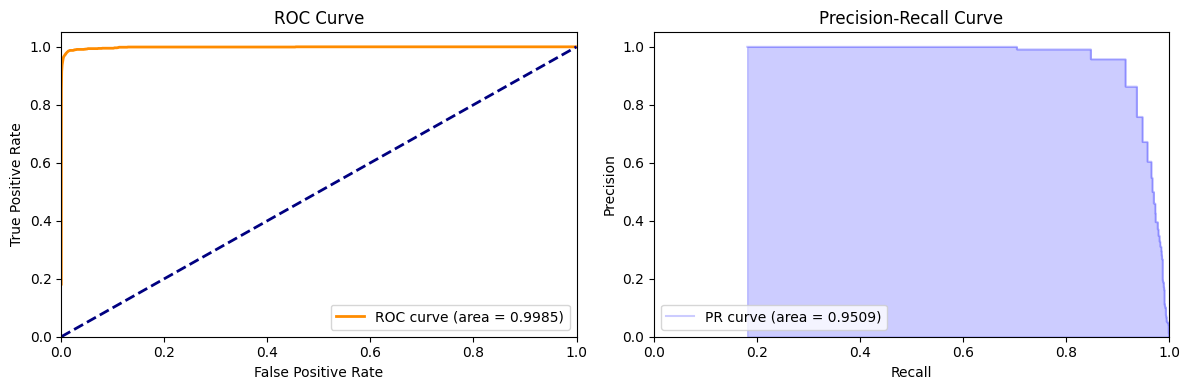

In [12]:
import numpy as np

# temporary fix for np.bool deprecation in handyspark
if not hasattr(np, 'bool'):
    np.bool = bool

from handyspark import BinaryClassificationMetrics as HandyBinaryClassificationMetrics
import matplotlib.pyplot as plt
bcm = HandyBinaryClassificationMetrics(
    predictions_balanced, scoreCol="probability", labelCol="is_fraud"
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
axs[0].set_title("ROC Curve")
axs[1].set_title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

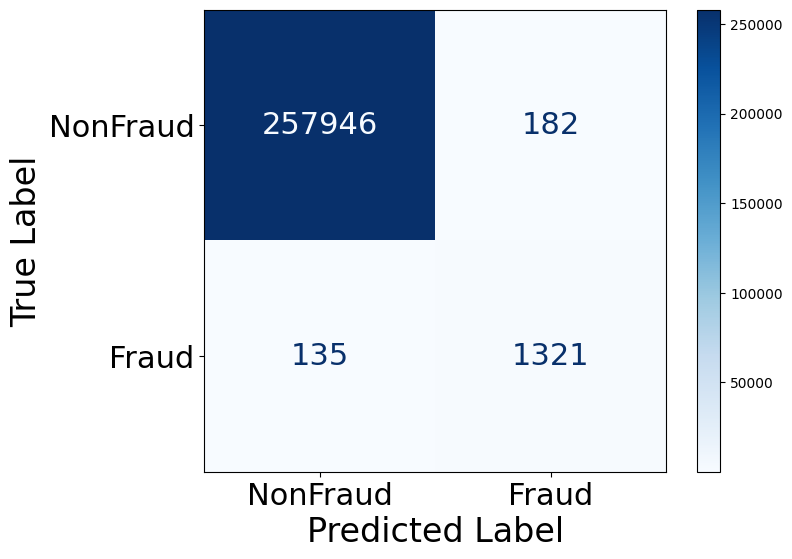

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = np.array([[2.57946e+05, 1.82000e+02],
                             [1.35000e+02, 1.32100e+03]])

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix.astype(int),
                              display_labels=["NonFraud", "Fraud"], )
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.title.set_fontsize(18)
ax.set_xlabel("Predicted Label", fontsize=24)
ax.set_ylabel("True Label", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=22)
for text in disp.text_.ravel():
    text.set_fontsize(22)

plt.show()

# CLF2 with PCA

In [64]:
valid_df = valid_df.drop("features")

In [65]:
balanced_df_smote.printSchema()

root
 |-- features: vector (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler

K = len(feature_columns)
pca = PCA(k=K, inputCol="scaledFeatures", outputCol="pca_features")

pipeline = Pipeline(stages=[scaler, pca])

pipeline_model = pipeline.fit(balanced_df_smote)

In [86]:
train_df_transformed = pipeline_model.transform(balanced_df_smote)
valid_df_prepared = assembler.transform(valid_df)
valid_df_transformed = pipeline_model.transform(valid_df_prepared)

explained_variance = pipeline_model.stages[1].explainedVariance.toArray()

Optimal k for 90.0% explained variance: 18


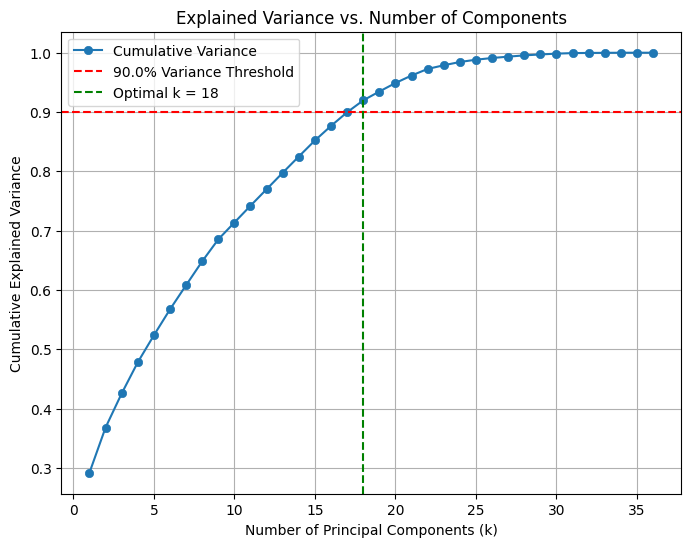

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

explained_variance = explained_variance.tolist()

cumulative_variance = []
cumulative_sum = 0
for var in explained_variance:
    cumulative_sum += var
    cumulative_variance.append(cumulative_sum)

variance_df = pd.DataFrame({
    'k': range(1, len(explained_variance) + 1),
    'explained_variance': explained_variance,
    'cumulative_variance': cumulative_variance
})

threshold = 0.9
optimal_k = next(i for i, total_variance in enumerate(cumulative_variance, 1) if total_variance >= threshold)

print(f"Optimal k for {threshold*100}% explained variance: {optimal_k}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.grid()
plt.show()

Threshold 90% to preserve information

In [89]:
pca_optimal = PCA(k=optimal_k, inputCol="features", outputCol="pca_features")
pipeline_optimal = Pipeline(stages=[scaler, pca_optimal])
pipeline_model_optimal = pipeline_optimal.fit(balanced_df_smote)

train_df_transformed = pipeline_model.transform(balanced_df_smote)
valid_df_prepared = assembler.transform(valid_df)
valid_df_transformed = pipeline_model.transform(valid_df_prepared)

In [90]:
# get optimal model from pipeline
pca_optimal_model = pipeline_model_optimal.stages[-1]

In [91]:
loadings = pca_optimal_model.pc.toArray()

loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=feature_columns)

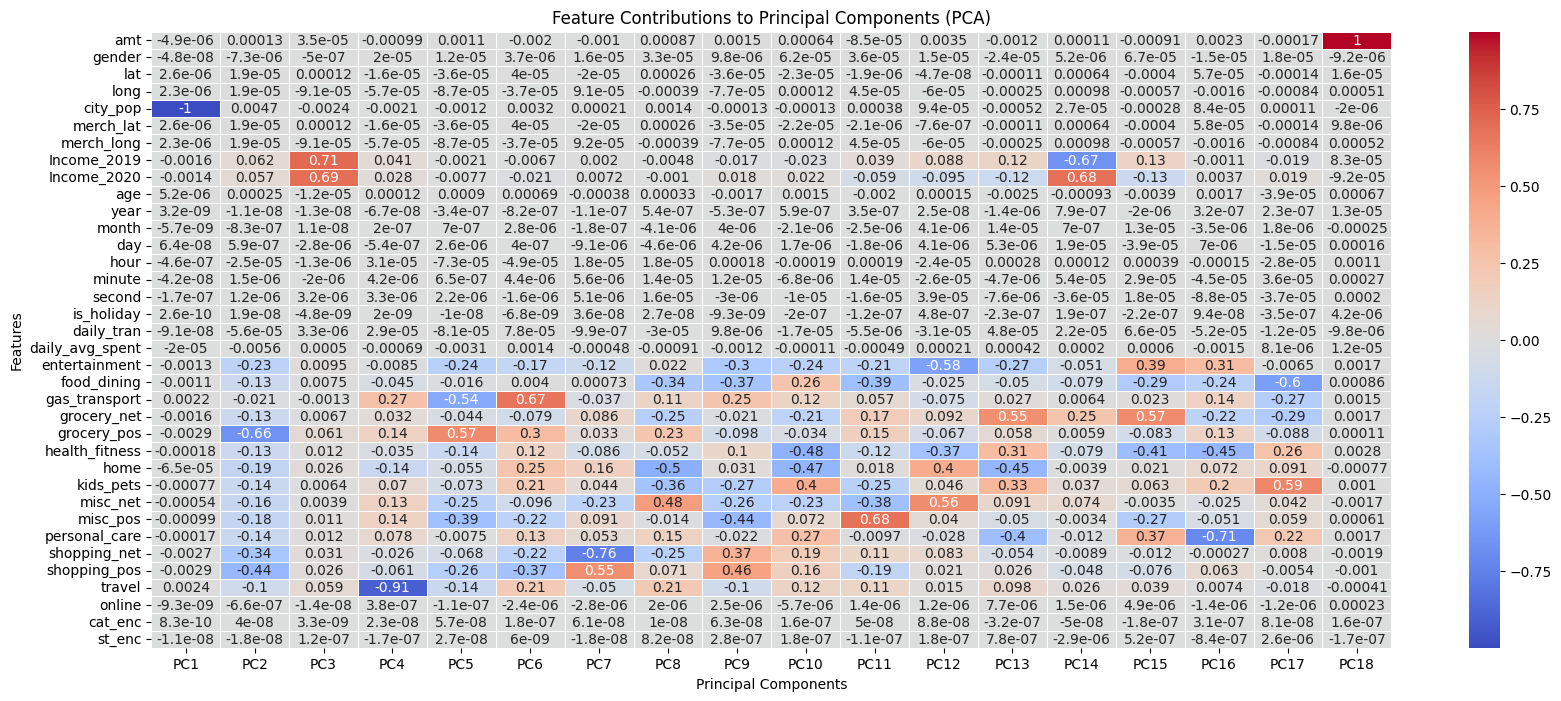

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# heatmap with feature contributions
plt.figure(figsize=(20, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Contributions to Principal Components (PCA)')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

In [93]:
train_df_transformed.groupBy("is_fraud").count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       0|302894|
|       1| 12100|
+--------+------+



In [94]:
train_df_transformed.printSchema()

root
 |-- features: vector (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [95]:
%%time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import multiprocessing

feature_columns = ['pca_features']

num_workers = multiprocessing.cpu_count()

xgb_classifier = SparkXGBClassifier(
    label_col="is_fraud",
    features_col="pca_features",
    num_workers=num_workers,
    device='cpu',
    num_boost_round=50,
    verbose_eval=True
)

pipeline = Pipeline(stages=[xgb_classifier])
xgb_model = pipeline.fit(train_df_transformed)

predictions = xgb_model.transform(valid_df_transformed)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
prediction_and_labels = predictions.select("prediction", "is_fraud").rdd.map(lambda row: (float(row['prediction']), float(row['is_fraud'])))

metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy
g_measure, jaccard_index = compute_metrics(predictions)

xgb_metrics = {
    "confusion_matrix": confusion_matrix,
    "precision": precision,
    "recall": recall,
    "f1_score": f1_score,
    "accuracy": accuracy,
    "g-measure": g_measure,
    "jaccard_index": jaccard_index,
    "roc_auc": roc_auc
}

print("XGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")

INFO:XGBoost-PySpark:Running xgboost-2.1.3 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


ROC-AUC on validation set: 0.9702652964935871


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


XGBoost Metrics:
confusion_matrix: [[257624.    504.]
 [   431.   1025.]]
precision: 0.670372792674951
recall: 0.7039835164835165
f1_score: 0.6867671691792295
accuracy: 0.996398083086785
g-measure: 0.6867671691792295
jaccard_index: 0.5229591836734694
roc_auc: 0.9702652964935871
CPU times: user 1.3 s, sys: 130 ms, total: 1.43 s
Wall time: 8min 38s


In [96]:
# save model
xgb_classifier_model_path = "/content/drive/MyDrive/DDAM Group 2/AM/xgb_model_balanced_onPCA"
xgb_model.stages[-1].write().overwrite().save(xgb_classifier_model_path)

'''
load:
from pyspark.ml import PipelineModel

# Load the entire pipeline model
loaded_pipeline_model = PipelineModel.load(pipeline_model_path)
'''

'\nload:\nfrom pyspark.ml import PipelineModel\n\n# Load the entire pipeline model\nloaded_pipeline_model = PipelineModel.load(pipeline_model_path)\n'

In [11]:
from xgboost.spark import SparkXGBClassifierModel
import pandas as pd

path = "/content/drive/MyDrive/DDAM Group 2/AM/xgb_model_balanced"
loaded_xgb_model = SparkXGBClassifierModel.load(path)

importances = loaded_xgb_model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame(list(importances.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

['amt',
 'gender',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'Income_2019',
 'Income_2020',
 'age',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'is_holiday',
 'daily_tran',
 'daily_avg_spent',
 'entertainment',
 'food_dining',
 'gas_transport',
 'grocery_net',
 'grocery_pos',
 'health_fitness',
 'home',
 'kids_pets',
 'misc_net',
 'misc_pos',
 'personal_care',
 'shopping_net',
 'shopping_pos',
 'travel',
 'online',
 'cat_enc',
 'st_enc']

In [12]:
import pandas as pd

feature_columns = [
    'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'Income_2019', 'Income_2020',
    'age', 'year', 'month', 'day', 'hour', 'minute', 'second', 'is_holiday', 'daily_tran', 'daily_avg_spent',
    'entertainment', 'food_dining', 'gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home',
    'kids_pets', 'misc_net', 'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel', 'online',
    'cat_enc', 'st_enc'
]

importances = loaded_xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importances.items()), columns=["Feature", "Importance"])

def map_feature_name(feature):
    feature_index = int(feature[1:])
    return feature_columns[feature_index] if feature_index < len(feature_columns) else "Unknown"

importance_df["Original_Feature"] = importance_df["Feature"].apply(map_feature_name)
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance,Original_Feature
34,f34,717.0,cat_enc
0,f0,642.0,amt
13,f13,312.0,hour
12,f12,289.0,day
11,f11,221.0,month
9,f9,166.0,age
21,f21,144.0,gas_transport
4,f4,139.0,city_pop
22,f22,119.0,grocery_net
32,f32,114.0,travel


# LIME

In [13]:
!pip install lime -q -q -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [105]:
balanced_df_smote.printSchema()

root
 |-- features: vector (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [14]:
from pyspark.sql import SparkSession
from xgboost.spark import SparkXGBClassifierModel
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.sql.functions import col

feature_columns = [
    'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'Income_2019', 'Income_2020',
    'age', 'year', 'month', 'day', 'hour', 'minute', 'second', 'is_holiday', 'daily_tran', 'daily_avg_spent',
    'entertainment', 'food_dining', 'gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home',
    'kids_pets', 'misc_net', 'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel', 'online',
    'cat_enc', 'st_enc'
]

features_df = balanced_df_smote.withColumn("features_array", vector_to_array(col("features")))
for i, feature in enumerate(feature_columns):
    features_df = features_df.withColumn(feature, col("features_array")[i])

background_sample_size = 100
background_df = features_df.select(*feature_columns).limit(background_sample_size)
background_data = background_df.rdd.map(lambda row: list(row)).collect()
background_data = np.array(background_data)

explainer = LimeTabularExplainer(
    training_data=background_data,
    feature_names=feature_columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification',
    discretize_continuous=True
)

In [23]:
valid_df_prepared = assembler.transform(valid_df)
valid_df_transformed = scaler.fit(balanced_df_smote).transform(valid_df_prepared)

In [24]:
from pyspark.sql.functions import col

# filter valid df where is_fraud = 1
instance_df = valid_df_transformed.filter(col("is_fraud") == 1) \
    .withColumn("features_array", vector_to_array(col("features")))

for i, feature in enumerate(feature_columns):
    instance_df = instance_df.withColumn(feature, col("features_array")[i])

instance_data = instance_df.select(*feature_columns).limit(1).rdd.map(lambda row: list(row)).collect()

In [29]:
instance_array = np.array(instance_data)[0]

xgb_classifier_model_path = "/content/drive/MyDrive/DDAM Group 2/AM/xgb_model_balanced"
loaded_xgb_model = SparkXGBClassifierModel.load(xgb_classifier_model_path)

from pyspark.ml.feature import VectorAssembler, MinMaxScaler

def predict_proba(input_array):
    input_list = input_array.tolist()
    schema = StructType([StructField(c, DoubleType(), True) for c in feature_columns])
    input_df = spark.createDataFrame(input_list, schema=schema)

    assembled_input = assembler.transform(input_df)
    transformed_input = scaler.fit(balanced_df_smote).transform(assembled_input)

    predictions = loaded_xgb_model.transform(transformed_input)

    prob_col = 'probability'
    probabilities = predictions.select(prob_col).rdd.map(lambda row: list(row[prob_col])).collect()
    return np.array(probabilities)

explanation = explainer.explain_instance(
    data_row=instance_array,
    predict_fn=predict_proba,
    num_features=5
)

print("LIME Explanation (as list):")
print(explanation.as_list())

explanation.show_in_notebook(show_table=True, show_all=False)

LIME Explanation (as list):
[('online <= 0.00', 0.5196657881947537), ('amt > 86.61', 0.11843663269346794), ('cat_enc > 0.09', 0.11809403068244889), ('hour <= 9.00', 0.05614739729233796), ('second > 46.00', -0.03150604887031996)]
